# Alpha Vantage: Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import alpha vantage
from alpha_vantage.timeseries import TimeSeries

In [3]:
#Config Alpha Vantage
# ts = TimeSeries(key="3P9NBZQR6NNO2VEF", output_format='pandas')
ts = TimeSeries(key="3P9NBZQR6NNO2VEF")

#### Alpha Vantage: Quote Endpoint (Verify API)

##### Test Quote Endpoint

In [4]:
# TEST: Get JSON Data
# ticker = "MSFT"
# data, _ = ts.get_quote_endpoint(ticker)

# price = data['05. price']
# date = data['07. latest trading day']

# print(f'{ticker}: {price}, {date}')

### OUTPUT ###
# MSFT: 329.4900, 2021-12-02 ###

# Alpha Vantage: Get Table

#### GET JSON DATA 

In [5]:
# INPUTS: Mock
portfolio = {
    "tickers": ["MSFT", "AAPL", "GOOGL"]
}

# FUNCTION: Get data
def get_price_full(ticker):
    data, _ = ts.get_daily_adjusted(ticker, 'full')
    return data

# GET JSON DATA INTO A DICTIONARY: {ticker: {}, ticker: {}}
stocks_hist_prices = {}

for ticker in portfolio["tickers"]: 
    price_array = get_price_full(ticker)
    stocks_hist_prices[ticker] = price_array

##### VALIDATE: Stock prices | Historical of 1 stock

In [6]:
# TEST: Get price of first stock in portfolio
for ticker in portfolio["tickers"]:
    price_ticker = stocks_hist_prices[ticker]['2021-12-01']['5. adjusted close']
    print(f'{ticker}: {price_ticker}')

MSFT: 330.08
AAPL: 164.77
GOOGL: 2821.03


In [7]:
# TEST: JSON -> DataFrame -> 1 year data
# df_msft = pd.DataFrame.from_dict(stocks_hist_prices['MSFT'], orient='index')

# # Post-Processing: Get 1 year data from one column
# df_msft = df_msft[['5. adjusted close']]
# df_msft = df_msft[:250]

# df_msft.tail()

#### Formatting: Generate dataframe: date | stock_1 |  ..  | stock_n

In [8]:
# Dataframes: Create dataframes then union into one long table
data_frames = []

for stock in stocks_hist_prices:

    df = pd.DataFrame.from_dict(stocks_hist_prices[stock], orient='index')

    # Get 1 year of data
    df = df[:250]

    # Get table with two columns: Ticker | Price
    df['ticker'] = stock
    df = df[['ticker','5. adjusted close']]

    # Post-Processing
    df.rename(columns={'5. adjusted close': 'adj_close'}, inplace=True, errors='raise')
    df['adj_close'] = df['adj_close'].astype('float64')

    # Add to array so we can union with other tables
    data_frames.append(df)

df_merged = pd.concat(data_frames)
df_merged.tail()

,ticker,adj_close
2020-12-11,GOOGL,1774.80
2020-12-10,GOOGL,1767.65
2020-12-09,GOOGL,1777.86
2020-12-08,GOOGL,1811.33
2020-12-07,GOOGL,1817.03


#### Create Pivot table

In [9]:
df_merged.reset_index(inplace=True)
df_merged.rename(columns= {"index": "date"}, inplace=True, errors='raise')
df_merged.head(2)

,date,ticker,adj_close
0,2021-12-02,MSFT,329.49
1,2021-12-01,MSFT,330.08


In [10]:
df_pivot = df_merged.pivot(index='date', columns='ticker')
df_pivot.head()

adj_close                     
ticker            AAPL    GOOGL        MSFT
date                                       
2020-12-07  122.992075  1817.03  212.509777
2020-12-08  123.618216  1811.33  214.215488
2020-12-09  121.034140  1777.86  210.040462
2020-12-10  122.485198  1767.65  208.771096
2020-12-11  121.660282  1774.80  211.488333

#### Create tables for daily and annual returns

In [11]:
# calculate daily and annual returns of the stocks
returns_daily = df_pivot.pct_change()
returns_annual = returns_daily.mean() * 250

In [2]:
print(returns_annual)

NameError: name 'returns_annual' is not defined

# Continuous weights (0,1) Monte Carlo

#### Get Raw Data

In [12]:

# import quandl

# quandl.ApiConfig.api_key = 'smWr-zbs_z2qHLFTPEht'

# selected = ['GOOGL', 'MSFT', 'AMZN']
# data = quandl.get_table('WIKI/PRICES', ticker = selected,
#                         qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
#                         date = { 'gte': '2016-1-1', 'lte': '2019-4-30' }, paginate=True)

# data.head(2)

#### Create Pivot Table

In [13]:

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
# clean = data.set_index('date')
# table = clean.pivot(columns='ticker')

# table.head(2)


#### Create tables for daily and annual returns

In [14]:

# calculate daily returns
# returns_daily = table.pct_change()
# returns_daily.tail()

In [15]:
# calculate annual returns
# returns_annual = returns_daily.mean() * 250
# returns_annual.tail()

### Simulation Config: 50 k

In [16]:
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(portfolio["tickers"])
num_portfolios = 50000

### Run Simulation
- #### Generate weights: Random: 0-1, Random(num): Sum of random floats = 1
- #### Generate weighted return & volatility
- #### Add to lists

In [17]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    returns = np.sum(weights * returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))

    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

### Create an object
##### { 'Returns': [], 'Volatility': [], 'MSFT Weight': NUM }

In [18]:

# a dictionary for Returns and Risk values of each portfolio
portfolio_stats = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(portfolio["tickers"]):
    portfolio_stats[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

### Create Dataframe

In [19]:

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio_stats)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in portfolio["tickers"]]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,MSFT Weight,AAPL Weight,GOOGL Weight
0,0.377752,0.216924,0.639390,0.336611,0.023999
1,0.419757,0.204982,0.365039,0.461641,0.173320
2,0.478409,0.228489,0.019908,0.864298,0.115794
3,0.412034,0.207156,0.418566,0.457179,0.124256
4,0.380806,0.207449,0.573882,0.071809,0.354308


In [20]:
df['sharpe_ratio'] = df['Returns']/df['Volatility']

# Get index with max Sharpe ratio
max_index = df['sharpe_ratio'].idxmax()

# Show weights
df.iloc[max_index]


Returns         0.466998
Volatility      0.198353
MSFT Weight     0.000614
AAPL Weight     0.266318
GOOGL Weight    0.733068
sharpe_ratio    2.354373
Name: 30327, dtype: float64

### Plot data with Seaborn

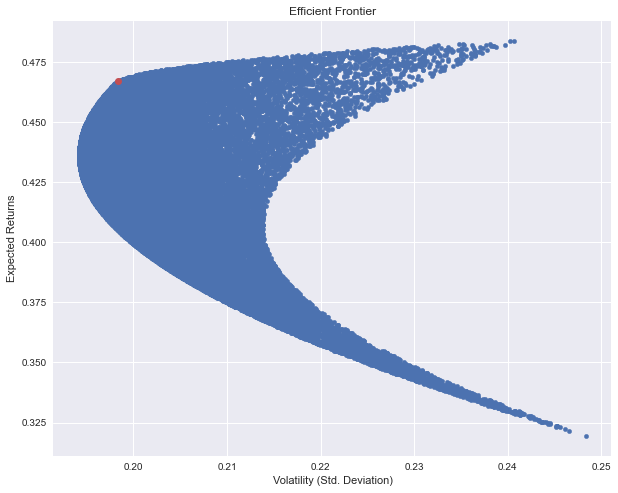

In [21]:

# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)

returns = np.array(port_returns)
risk = np.array(port_volatility)
max_idx = np.where(returns / risk == np.max(returns / risk))[0][0]
plt.plot(port_volatility[max_idx], port_returns[max_idx], 'o', color='C2')

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

### Get optimal weights

In [22]:
# Get Optimal: max_ratio = MAX(return / risk)
returns = np.array(port_returns)
risk = np.array(port_volatility)
max_ratio = np.max(returns/risk)

print(max_ratio)

2.3543728707329312


In [23]:
# Get array with max weight
max_idx = np.where(returns/risk == max_ratio)

print(max_idx[0][0])


30327


In [24]:

# Get weights
opt_weights = stock_weights[max_idx[0][0]]
opt_weights

array([6.14004596e-04, 2.66318494e-01, 7.33067501e-01])

#### Check: Sum of weights = 1

In [25]:
np.sum(opt_weights)

1.0